In [26]:
# Standard Libraries
import warnings

#  Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.pyplot as plt
import finplot as fplt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae,root_mean_squared_error as rmse
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from joblib import dump

In [27]:
aapl = yf.Ticker('AAPL')
start_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
aapl_history = aapl.history(start=start_date, end=end_date)
aapl_history.index = aapl_history.index.date
print(aapl_history)


                  Open        High         Low       Close     Volume  \
2010-01-04    6.407192    6.439313    6.375671    6.424603  493729600   
2010-01-05    6.442318    6.472038    6.401791    6.435714  601904800   
2010-01-06    6.435713    6.461230    6.326739    6.333344  552160000   
2010-01-07    6.356761    6.364266    6.275706    6.321637  477131200   
2010-01-08    6.313231    6.364265    6.276007    6.363665  447610800   
...                ...         ...         ...         ...        ...   
2025-08-19  231.279999  232.869995  229.350006  230.559998   39402600   
2025-08-20  229.979996  230.470001  225.770004  226.009995   42263900   
2025-08-21  226.270004  226.520004  223.779999  224.899994   30621200   
2025-08-22  226.169998  229.089996  225.410004  227.759995   42445300   
2025-08-25  226.404999  229.300003  226.240005  227.160004   30934672   

            Dividends  Stock Splits  
2010-01-04        0.0           0.0  
2010-01-05        0.0           0.0  
2010-01-0

In [28]:
# Checking for null and duplicates
print("Number of null values",aapl_history.isna().sum())
duplicates = aapl_history.duplicated().sum()
print('The Sum of Duplicates', duplicates)

Number of null values Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
The Sum of Duplicates 0


## **__FEATURE ENGINEERING__**

In [29]:
def rolling_averages(df, windows=[5, 10, 20]):
    '''
    adds rolling average to the dataframe
    windows:List of window sizes for rolling averages
    '''
    df = df.copy()
    for window in windows:
        df[f'rolling_mean_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['Close'].rolling(window=window).std()
    
    df.dropna(inplace=True)  # Drop rows with NaN values after rolling calculations
    return df

In [30]:
aapl_history = rolling_averages(aapl_history)

## **__DATA VISUALIZATION__**

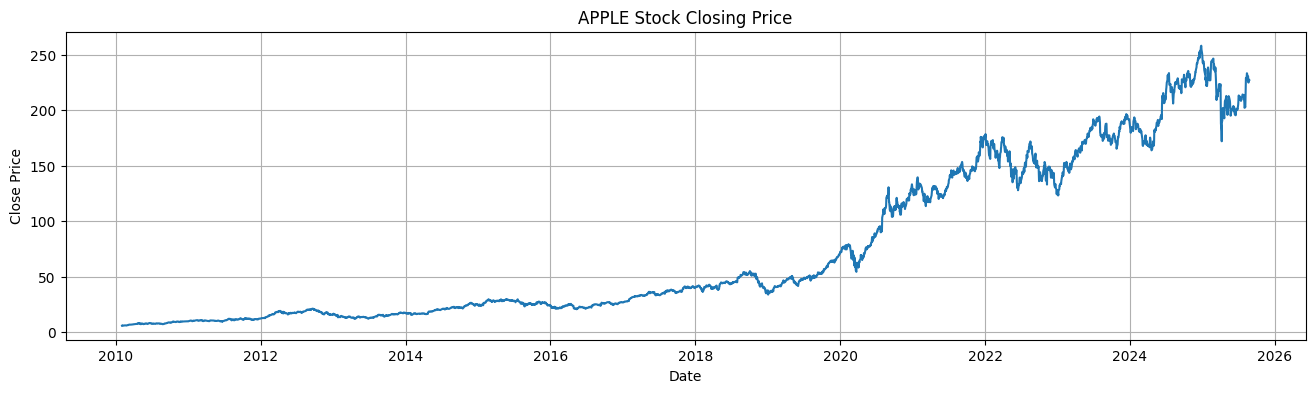

In [31]:
plt.figure(figsize=(16, 4))
plt.title('APPLE Stock Closing Price')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(aapl_history['Close'])
plt.show()

In [32]:
# fplt.candlestick_ochl(appl_history[['Close', 'High', 'Open', 'Low']])
# fplt.show()

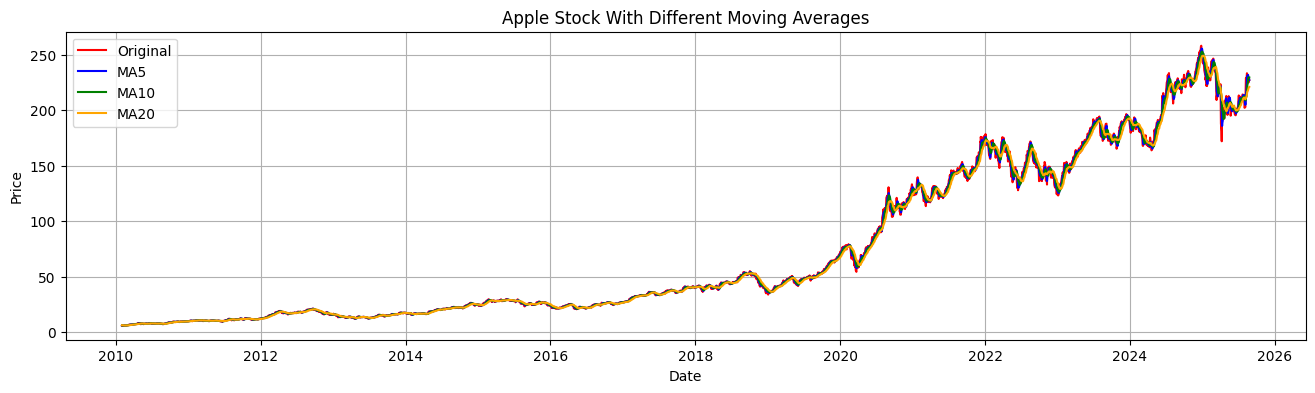

In [33]:
plt.figure(figsize=(16,4))
plt.title('Apple Stock With Different Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(aapl_history['Close'], label='Original', color='red')
plt.plot(aapl_history['rolling_mean_5'], label='MA5', color='blue')
plt.plot(aapl_history['rolling_mean_10'], label='MA10', color='green')
plt.plot(aapl_history['rolling_mean_20'], label='MA20', color='orange')
plt.legend()
plt.grid()
plt.show();

In [34]:
def test_stationarity(df):
    """
    Performs the Augmented Dickey-Fuller test to check stationarity of a time series.

    Parameters:
        df (pd.Series): Time series data.

    Returns:
        pd.Series or None
    """
    if df is None or df.empty:
        print("Error: Input series is empty.")
        return None
    if df.nunique() == 1:
        print("Error: Input series is constant.")
        return None

    print("ADF TEST STATISTIC: ")
    adft = adfuller(df, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number Of Observations Used'])
    for key, values in adft[4].items():
        output[f'Critical Value ({key})'] = values
    print(output)
    if adft[1] <= 0.05:
        print('Data Is Stationary')
        return df.dropna()
    else:
        print('Data Is Not Stationary. Consider Differencing The Data.')
        return None

In [35]:
print(test_stationarity(aapl_history['Close']))

ADF TEST STATISTIC: 
Test Statistic                    0.737660
p-value                           0.990560
Lags Used                        31.000000
Number Of Observations Used    3884.000000
Critical Value (1%)              -3.432035
Critical Value (5%)              -2.862284
Critical Value (10%)             -2.567166
dtype: float64
Data Is Not Stationary. Consider Differencing The Data.
None


<Figure size 640x480 with 0 Axes>

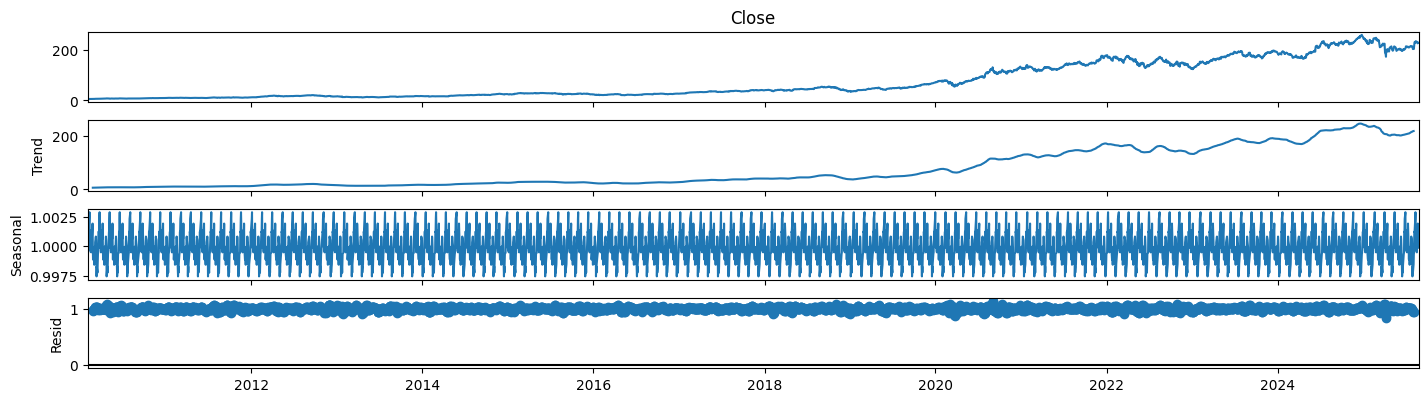

In [36]:
results = seasonal_decompose(aapl_history['Close'], model='multiplicative', period=30)
fig = plt.figure()
fig = results.plot()
fig.set_size_inches(16, 4);

In [37]:
df_log = np.log(aapl_history['Close'])
print(test_stationarity(df_log))

ADF TEST STATISTIC: 
Test Statistic                   -1.070531
p-value                           0.726680
Lags Used                         9.000000
Number Of Observations Used    3906.000000
Critical Value (1%)              -3.432025
Critical Value (5%)              -2.862280
Critical Value (10%)             -2.567164
dtype: float64
Data Is Not Stationary. Consider Differencing The Data.
None


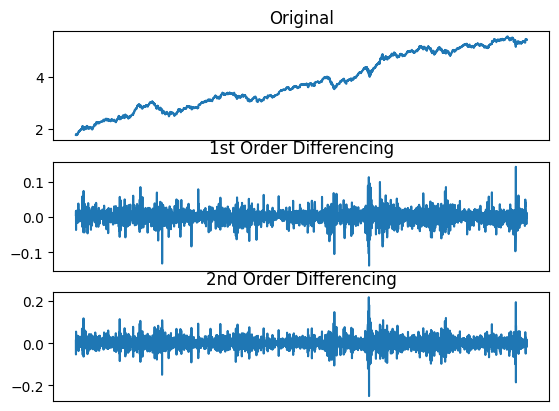

ADF TEST STATISTIC: 
Test Statistic                  -21.090098
p-value                           0.000000
Lags Used                         8.000000
Number Of Observations Used    3906.000000
Critical Value (1%)              -3.432025
Critical Value (5%)              -2.862280
Critical Value (10%)             -2.567164
dtype: float64
Data Is Stationary
2010-02-02    0.005786
2010-02-03    0.017060
2010-02-04   -0.036704
2010-02-05    0.017600
2010-02-08   -0.006879
                ...   
2025-08-19   -0.001430
2025-08-20   -0.019932
2025-08-21   -0.004923
2025-08-22    0.012637
2025-08-25   -0.002638
Name: Close, Length: 3915, dtype: float64


In [38]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df_log)
ax1.axes.xaxis.set_visible(False)
ax1.set_title('Original')
ax2.plot(df_log.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)
ax3.plot(df_log.diff().diff())
ax3.set_title('2nd Order Differencing')
ax3.axes.xaxis.set_visible(False)
plt.show()

# First Order Differencing
print(test_stationarity(df_log.diff().dropna()))

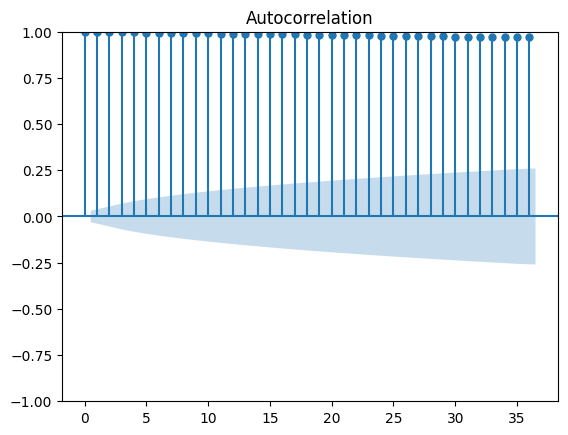

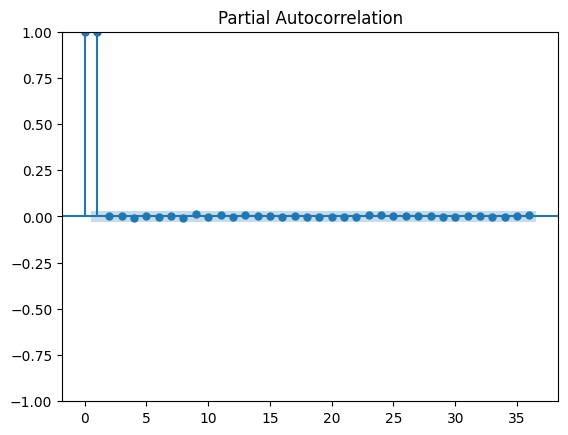

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf = plot_acf(df_log)
pafc = plot_pacf(df_log)


## **__Model Building__**
- 1.Linear Regression
- 2.Arima 

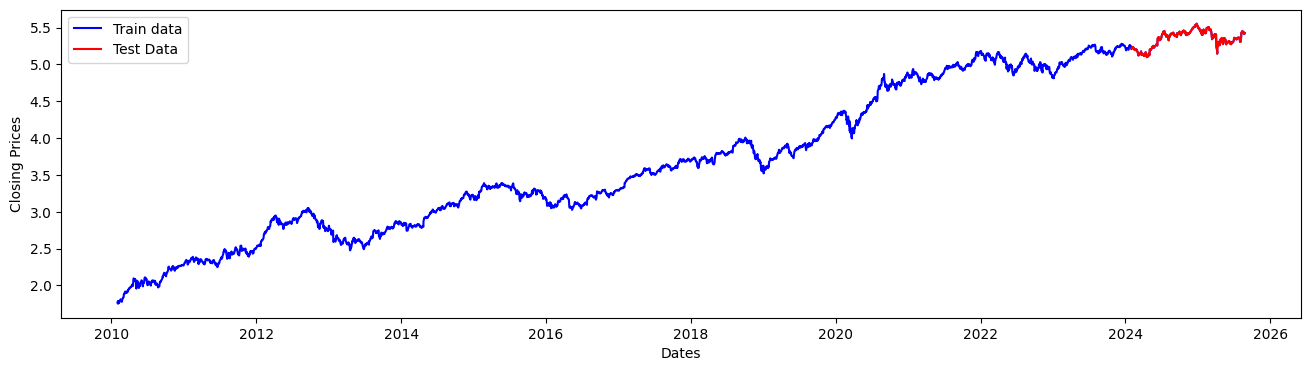

In [40]:
train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(16, 4))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test Data')
plt.legend()
plt.grid()
plt.show();

In [41]:
model_autoARIMA = auto_arima(
            train_data,
            test='adf',
            start_p=0, start_q=0,
            max_p=5, max_q=5,
            seasonal=False,
            d=None,
            D=0,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18414.803, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18418.991, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-18418.940, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18406.104, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-18417.049, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18417.222, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-18415.029, Time=1.80 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-18409.390, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 4.094 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3524
Model:               SARIMAX(1, 1, 0)   Log Likelihood                9212.496
Date:                Tue, 26 Aug 2025   AIC                         -18418.991
Time:               

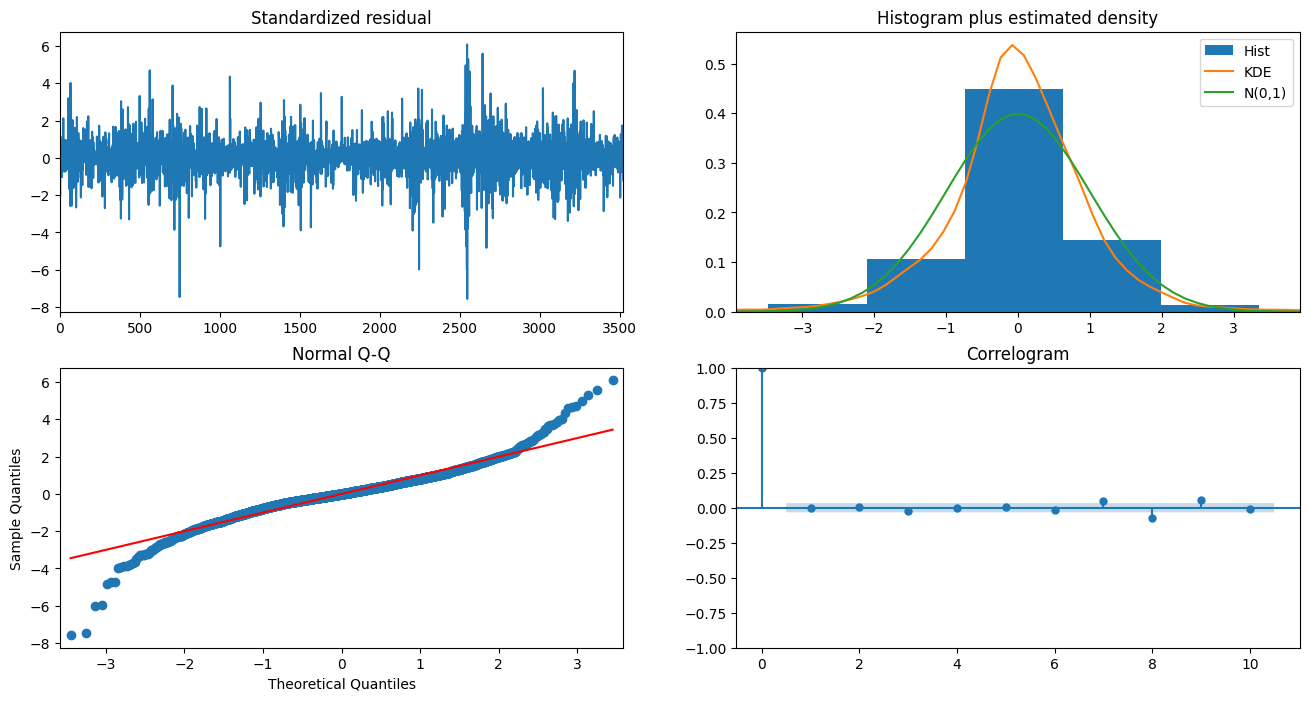

In [42]:
model_autoARIMA.plot_diagnostics(figsize=(16, 8))
plt.show()

In [43]:
arima_model = ARIMA(train_data, order=(1,1,0))
fitted = arima_model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3524
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9206.695
Date:                Tue, 26 Aug 2025   AIC                         -18409.390
Time:                        02:48:35   BIC                         -18397.056
Sample:                             0   HQIC                        -18404.990
                               - 3524                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0387      0.011     -3.456      0.001      -0.061      -0.017
sigma2         0.0003   4.19e-06     75.034      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.03   Jarque-

c:\Users\Langa\Desktop\Python\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Langa\Desktop\Python\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Langa\Desktop\Python\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [44]:
fc = fitted.get_forecast(steps=len(test_data), alpha=0.05).summary_frame()
fc.set_index([test_data.index],inplace=True)
print(fc)

Close           mean   mean_se  mean_ci_lower  mean_ci_upper
2024-02-01  5.209434  0.017734       5.174676       5.244191
2024-02-02  5.209404  0.024599       5.161192       5.257617
2024-02-05  5.209405  0.029943       5.150717       5.268093
2024-02-06  5.209405  0.034469       5.141848       5.276962
2024-02-07  5.209405  0.038465       5.134015       5.284795
...              ...       ...            ...            ...
2025-08-19  5.209405  0.336326       4.550218       5.868592
2025-08-20  5.209405  0.336759       4.549370       5.869441
2025-08-21  5.209405  0.337192       4.548522       5.870289
2025-08-22  5.209405  0.337623       4.547675       5.871135
2025-08-25  5.209405  0.338055       4.546830       5.871981

[392 rows x 4 columns]


c:\Users\Langa\Desktop\Python\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Langa\Desktop\Python\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Langa\Desktop\Python\my_env\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


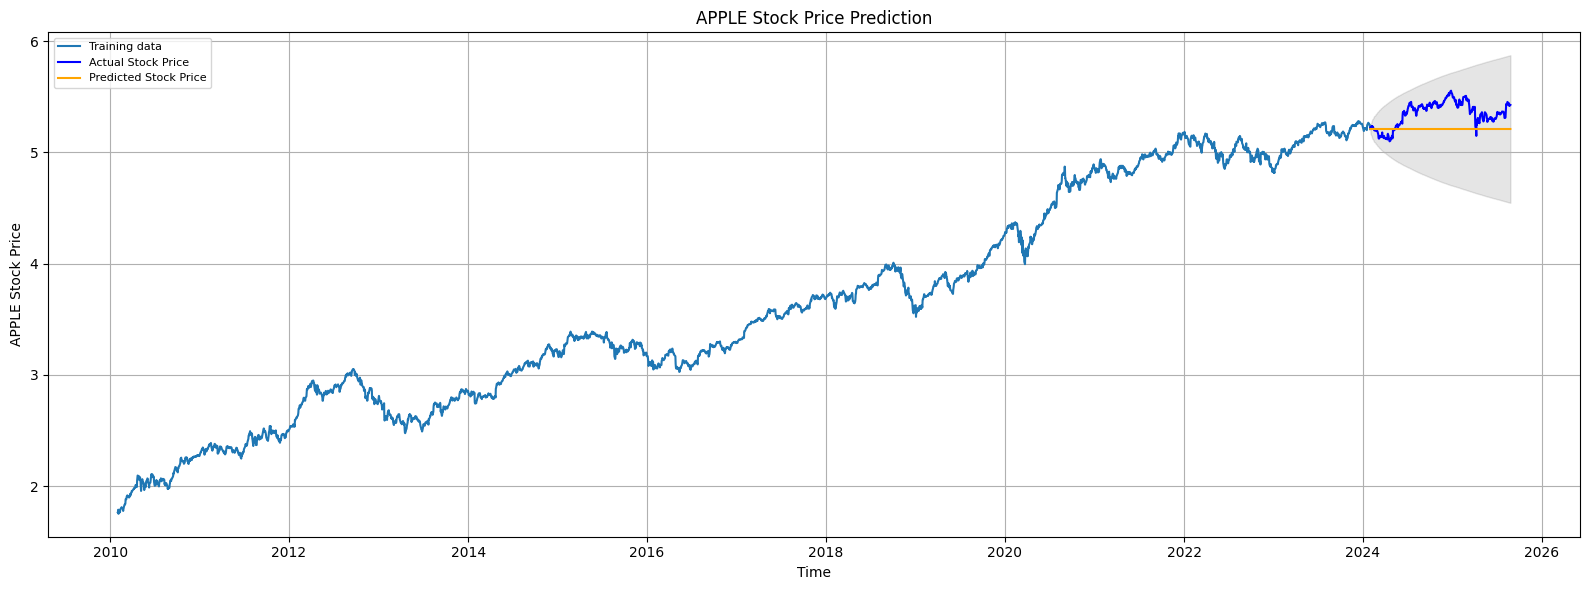

In [45]:
predicted = fc['mean']
lower_conf = fc['mean_ci_lower']
upper_conf = fc['mean_ci_upper']

# Plot
plt.figure(figsize=(16,6), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(predicted, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_conf.index, lower_conf, upper_conf, color='k', alpha=.10)
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.grid()
plt.savefig('assets/ARIMA_Forecast.jpeg')
plt.show()

In [46]:
# report performance

fc_mean = fc.iloc[:,0]
fc_mean = np.array(fc_mean)
predicted = np.array(predicted)
test_array = np.array(test_data)

print('test data shape: ', test_array.shape)
print('predicted shape: ', predicted.shape)

arima_mape = np.mean(np.abs(test_array - fc_mean) / test_array) * 100
arima_accurary = 100 - arima_mape

print(f"MAPE : {arima_mape:.4f}%")
print(f"Approximate Accuracy: {arima_accurary: .4f}%")

mse_value = mse(test_data, predicted)
print('MSE: '+str(mse_value))
mae_value = mae(test_data, predicted)
print('MAE: '+str(mae_value))
rmse_value = rmse (test_data, predicted)
print('RMSE: '+str(rmse_value))

test data shape:  (392,)
predicted shape:  (392,)
MAPE : 2.8795%
Approximate Accuracy:  97.1205%
MSE: 0.031210837254562897
MAE: 0.1554868286289155
RMSE: 0.176665891599264


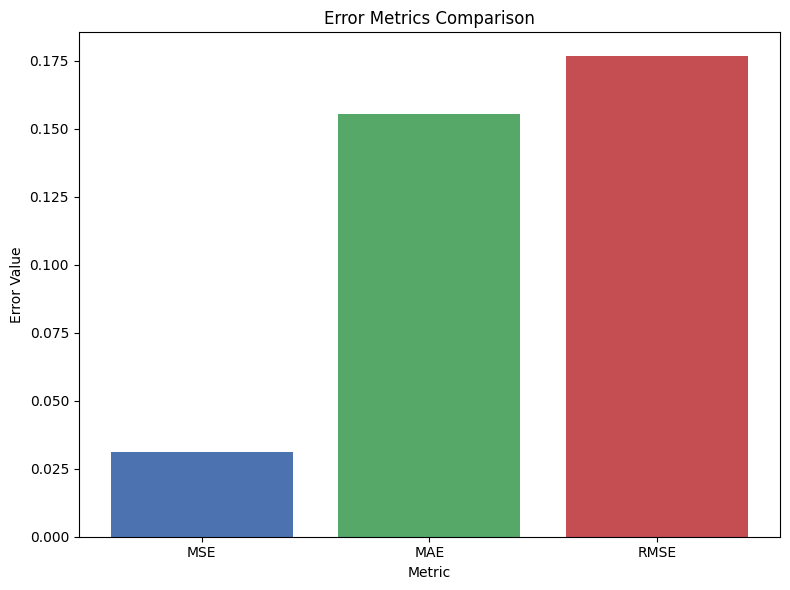

In [59]:
# Plotting
metrics = ['MSE', 'MAE', 'RMSE']
values = [mse_value, mae_value, rmse_value]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['#4c72b0', '#55a868', '#c44e52'])
plt.title('Error Metrics Comparison')
plt.ylabel('Error Value')
plt.xlabel('Metric')
plt.tight_layout()
plt.savefig('assets/arima_metrics.jpeg')
plt.show()

In [47]:
metrics = pd.DataFrame({
    'MODEL':[arima_model],
    'Forecast':[fc],
    'MSE': [mse_value],
    'MAE': [mae_value],
    'RMSE': [rmse_value],
    'MAPE' : [arima_mape],
    'Accuracy' : [arima_accurary]
})

dump(arima_model, 'models/arima_model.joblib')



['models/arima_model.joblib']

In [48]:
predicted = pd.DataFrame(predicted)
appl_history = pd.DataFrame(aapl_history)

fc.to_csv('data/Arima_forecast.csv')
aapl_history.to_csv('data/Apple_Proceessed_StockData.csv')
predicted.to_csv('data/ARIMA_Results.csv')
metrics.to_csv('data/ARIMA_metrics.csv')

In [49]:
# Step 1: Convert Series to NumPy array
train_array = train_data.to_numpy()
test_array = test_data.to_numpy()

# Step 2: Create lagged features
def create_lagged_features(series, lags):
    X, y = [], []
    for i in range(lags, len(series)):
        X.append(series[i-lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

lags = 3  # You can adjust this
X_train, y_train = create_lagged_features(train_array, lags)

# Step 3: Fit the model
LinearReg_model = LinearRegression()
fitted_model = LinearReg_model.fit(X_train, y_train)

# Step 4: Forecast recursively
last_input = train_array[-lags:]
forecast = []

for _ in range(len(test_array)):
    next_pred = fitted_model.predict(last_input.reshape(1, -1))[0]
    forecast.append(next_pred)
    last_input = np.roll(last_input, -1)
    last_input[-1] = next_pred

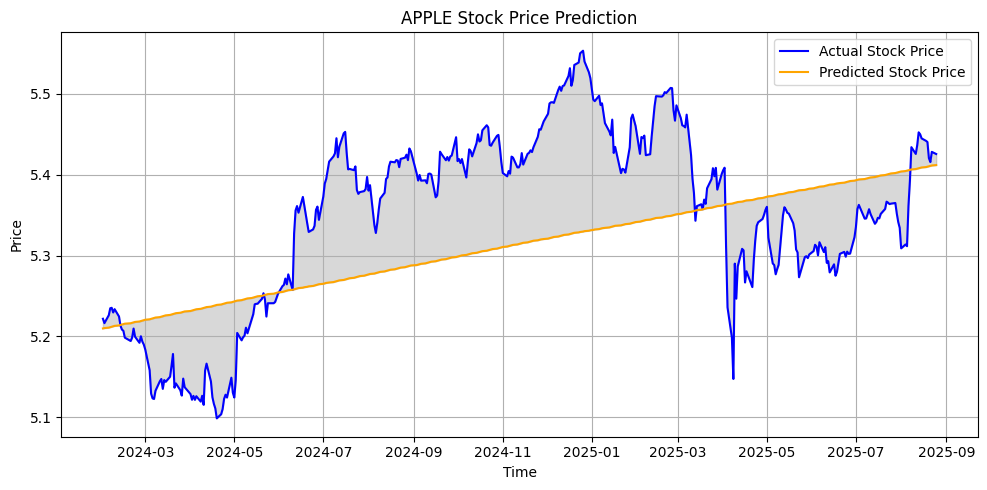

In [50]:
# Wrap forecast in a Series (assuming forecast and test_data are 1D)
forecast_series = pd.Series(forecast, index=test_data.index)

# Plot actual vs forecast
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data.values, color='blue', label='Actual Stock Price')
plt.plot(test_data.index, forecast_series.values, color='orange', label='Predicted Stock Price')

# Optional: fill between if you have prediction intervals
# For now, let's fill between actual and predicted to show the gap
plt.fill_between(test_data.index, test_data.values, forecast_series.values, color='gray', alpha=0.3)

plt.title('APPLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('assets/LinearRegression_forecast.jpeg')
plt.show()

In [51]:
# Model Performace
mse_result = mse(test_data, forecast)
mae_result = mae(test_data, forecast)
rmse_result =np.sqrt(mse_result)

LinearReg_mape = np.mean(np.abs(test_array - forecast) / test_array) * 100
LinearReg_accuracy = 100 - LinearReg_mape

print(f"MAPE : {LinearReg_mape:.4f}%")
print(f"Approximate Accuracy: {LinearReg_accuracy: .4f}%")
print(f"MSE: {mse_result:.4f}")
print(f"MAE: {mae_result:.4f}")
print(f"RMSE: {rmse_result:.4f}")


MAPE : 1.6675%
Approximate Accuracy:  98.3325%
MSE: 0.0106
MAE: 0.0896
RMSE: 0.1027


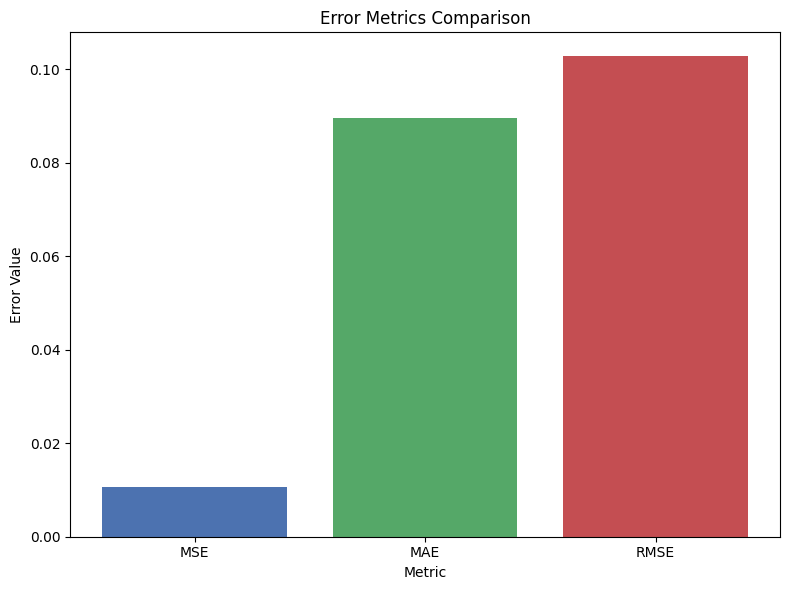

In [61]:
# Plotting
metrics = ['MSE', 'MAE', 'RMSE']
values = [mse_result, mae_result, rmse_result]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['#4c72b0', '#55a868', '#c44e52'])
plt.title('Error Metrics Comparison')
plt.ylabel('Error Value')
plt.xlabel('Metric')
plt.tight_layout()
plt.savefig('assets/LinearRegression_metrics.jpeg')
plt.show()

In [52]:
# Print side-by-side comparison
metrics = pd.DataFrame({
    'MODEL': [LinearReg_model],
    'Forecast': [forecast_series],
    'MSE':[mse_result],
    'MAE':[mae_result],
    'RMSE':[rmse_result],
    "MAPE": [LinearReg_mape],
    "accuracy" : [LinearReg_accuracy], 
})

print(results);

In [53]:
predicted = pd.DataFrame(predicted)
metrics = metrics = pd.DataFrame(metrics)
forecast_series.to_csv('data/LinearReg_Forecast.csv')
predicted.to_csv('data/LinearReg_predictions.csv')
metrics.to_csv('data/LinearReg_metrics.csv')
dump(LinearReg_model, 'models/LinearReg_model.joblin')

['models/LinearReg_model.joblin']